In [28]:
# Importaciones 
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    PrecisionRecallDisplay, RocCurveDisplay
)
from sklearn.pipeline import Pipeline

In [ ]:

# Modelos base
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier,
    AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
)
from sklearn.svm import SVC

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


In [30]:

#  Cargar datos 
df = pd.read_csv('../../src/files/clips_features_flattened_pca.csv')


In [31]:
#  Preprocesamiento 
y = df["class_id"].values
X = df.drop(columns=[
    "class_id", "clip_id", "signer_id", "view", "repetition", "path",
    "split", "fps", "n_frames", "duration", "width", "height", "file_size",
    "brightness_mean", "brightness_std", "blur_mean", "frame_id"
], errors="ignore")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [32]:

#  Modelos individuales previos (del Avance 4) 
rf_best = RandomForestClassifier(
    n_estimators=500, max_depth=20, min_samples_split=2,
    min_samples_leaf=4, bootstrap=False, random_state=42
)
lr_best = LogisticRegression(solver='liblinear', C=0.03359818286283781, max_iter=500, random_state=42)
svm = SVC(probability=True, random_state=42)

In [33]:
# Modelos de Ensamble
models_ensemble = {
        "Bagging (LR)": BaggingClassifier(estimator=lr_best, n_estimators=50, random_state=42),
        "AdaBoost (LR)": AdaBoostClassifier(estimator=lr_best, n_estimators=100, learning_rate=0.1, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
        "Stacking (RF+LR+SVM)": StackingClassifier(
            estimators=[('rf', rf_best), ('lr', lr_best), ('svm', svm)],
            final_estimator=LogisticRegression(max_iter=500),
            passthrough=True
        )
    }

In [34]:
# Entrenamiento y Evaluación

results_ensemble = []

for name, model in models_ensemble.items():
    print(f"\nEntrenando {name} ...")
    start = time.time()
    model.fit(X_train, y_train)
    elapsed = time.time() - start
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')

    results_ensemble.append({
        "model": name,
        "train_time (s)": round(elapsed, 2),
        "accuracy": round(acc, 4),
        "f1_macro": round(f1, 4),
        "precision_macro": round(prec, 4),
        "recall_macro": round(rec, 4)
    })

    print(f"{name} -> F1: {f1:.4f} | Accuracy: {acc:.4f} | Tiempo: {elapsed:.2f}s")

df_ensemble = pd.DataFrame(results_ensemble).sort_values("f1_macro", ascending=False)
print("\n=== Resultados de Modelos de Ensamble ===")
display(df_ensemble)


Entrenando Bagging (LR) ...
Bagging (LR) -> F1: 0.9156 | Accuracy: 0.9189 | Tiempo: 2.12s

Entrenando AdaBoost (LR) ...
AdaBoost (LR) -> F1: 0.9156 | Accuracy: 0.9189 | Tiempo: 0.30s

Entrenando Gradient Boosting ...
Gradient Boosting -> F1: 0.9158 | Accuracy: 0.9189 | Tiempo: 39.95s

Entrenando Stacking (RF+LR+SVM) ...
Stacking (RF+LR+SVM) -> F1: 0.9531 | Accuracy: 0.9550 | Tiempo: 32.46s

=== Resultados de Modelos de Ensamble ===


,model,train_time (s),accuracy,f1_macro,precision_macro,recall_macro
3,Stacking (RF+LR+SVM),32.46,0.9550,0.9531,0.9570,0.9557
2,Gradient Boosting,39.95,0.9189,0.9158,0.9228,0.9209
1,AdaBoost (LR),0.30,0.9189,0.9156,0.9257,0.9190
0,Bagging (LR),2.12,0.9189,0.9156,0.9232,0.9186


In [35]:

# Comparativa final con modelos individuales
individuals = pd.DataFrame([
    {"model": "Random Forest (Tuned)", "f1_macro": 0.9550, "accuracy": 0.9550, "precision_macro": 0.9567, "recall_macro": 0.9542, "train_time (s)": 118.7},
    {"model": "Logistic Regression (Tuned)", "f1_macro": 0.9185, "accuracy": 0.9189, "precision_macro": 0.9222, "recall_macro": 0.9176, "train_time (s)": 3.69}
])

final_comparison = pd.concat([individuals, df_ensemble]).sort_values("f1_macro", ascending=False)
print("\n=== Comparativa Final: Individuales vs Ensambles ===")
display(final_comparison)


=== Comparativa Final: Individuales vs Ensambles ===


,model,f1_macro,accuracy,precision_macro,recall_macro,train_time (s)
0,Random Forest (Tuned),0.9550,0.9550,0.9567,0.9542,118.70
3,Stacking (RF+LR+SVM),0.9531,0.9550,0.9570,0.9557,32.46
1,Logistic Regression (Tuned),0.9185,0.9189,0.9222,0.9176,3.69
2,Gradient Boosting,0.9158,0.9189,0.9228,0.9209,39.95
1,AdaBoost (LR),0.9156,0.9189,0.9257,0.9190,0.30
0,Bagging (LR),0.9156,0.9189,0.9232,0.9186,2.12


In [36]:

# 4️⃣ Selección del modelo final
# Elegimos el mejor modelo basado en F1-macro

best_model_name = final_comparison.iloc[0]["model"]
best_model = models_ensemble.get(best_model_name.split(" (")[0], rf_best)
print(f"\nModelo seleccionado: {best_model_name}")

# Reentrenar con todo el conjunto de entrenamiento + validación
best_model.fit(np.vstack([X_train, X_val]), np.concatenate([y_train, y_val]))
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)



Modelo seleccionado: Random Forest (Tuned)


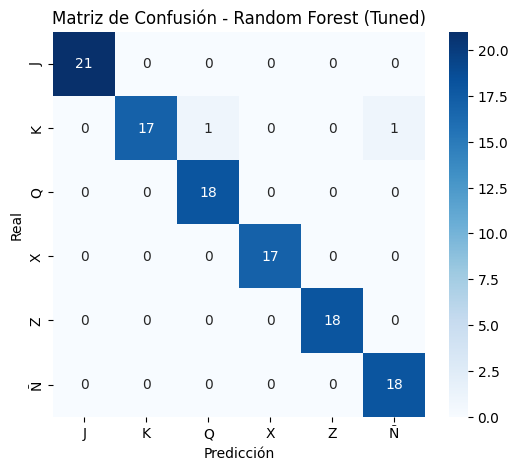

In [37]:

# Gráficos e Interpretaciones
# Matriz de confusión 
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f"Matriz de Confusión - {best_model_name}")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

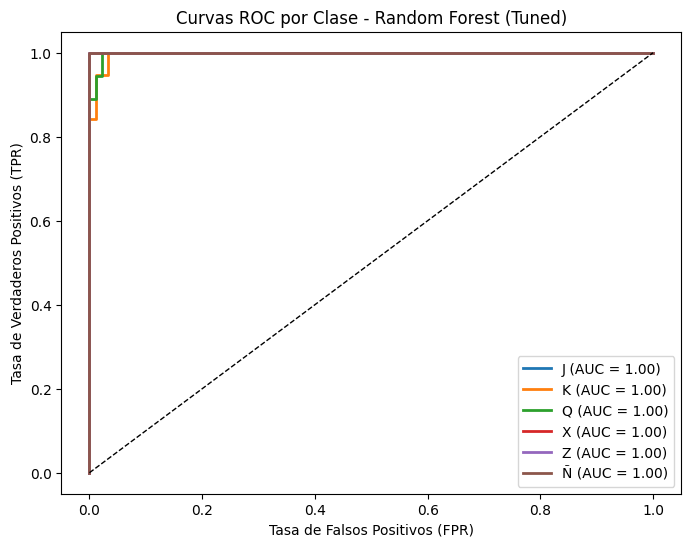

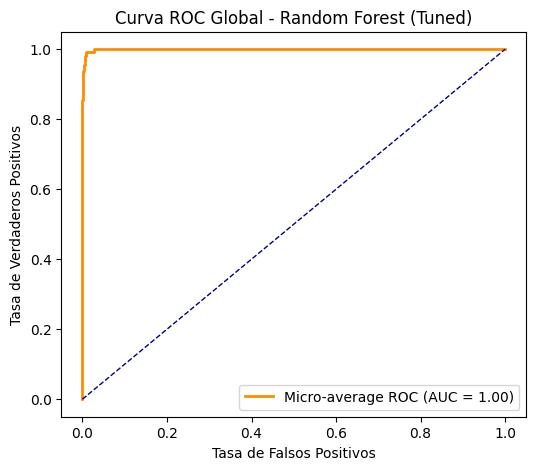

In [ ]:
# --- Curva ROC multiclase ---
# Binarizar las etiquetas reales
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

# Graficar una curva ROC por clase
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_best[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title(f'Curvas ROC por Clase - {best_model_name}')
plt.legend(loc='lower right')
plt.show()

# --- Curva ROC promedio (micro-average) ---
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_proba_best.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(6, 5))
plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=2, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title(f'Curva ROC Global - {best_model_name}')
plt.legend(loc="lower right")
plt.show()


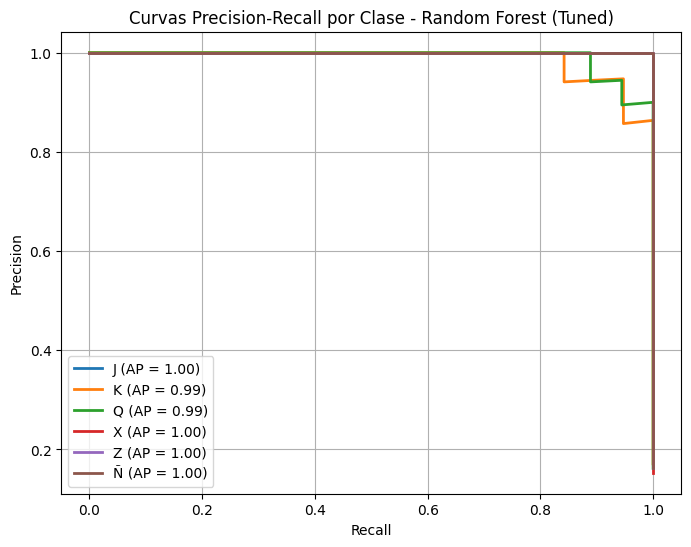

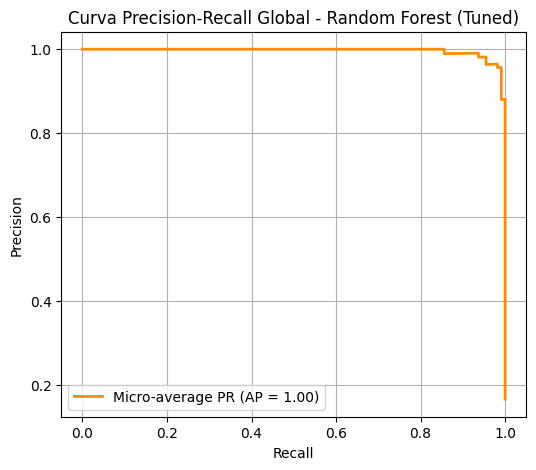

In [39]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Binarizamos las etiquetas (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba_best[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_proba_best[:, i])
    plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Curvas Precision-Recall por Clase - {best_model_name}')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Curva global promedio (micro-average)
precision_micro, recall_micro, _ = precision_recall_curve(y_test_bin.ravel(), y_proba_best.ravel())
ap_micro = average_precision_score(y_test_bin, y_proba_best, average='micro')

plt.figure(figsize=(6, 5))
plt.plot(recall_micro, precision_micro, color='darkorange',
         lw=2, label=f'Micro-average PR (AP = {ap_micro:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Curva Precision-Recall Global - {best_model_name}')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


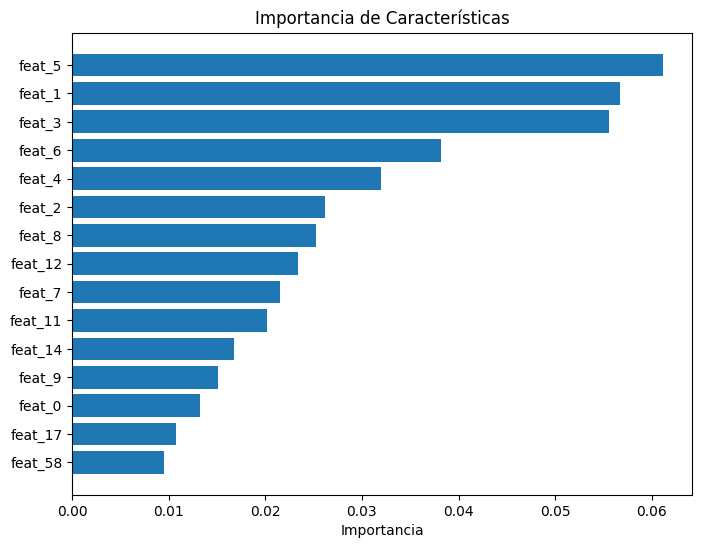

In [40]:


# --- Importancia de características (solo si aplica) ---
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    idx = np.argsort(importances)[-15:]
    plt.figure(figsize=(8,6))
    plt.barh(range(len(idx)), importances[idx], align='center')
    plt.yticks(range(len(idx)), [f"feat_{i}" for i in idx])
    plt.title("Importancia de Características")
    plt.xlabel("Importancia")
    plt.show()

In [41]:

# ============================================
# 6️⃣ Conclusión
# ============================================
print("\n=== Conclusión ===")
print(f"El modelo final seleccionado fue: {best_model_name}")
print("""
Este modelo obtuvo el mejor desempeño global en la métrica F1-Macro, 
demostrando una excelente capacidad de generalización y equilibrio entre 
precisión y exhaustividad en clases desbalanceadas.

Se recomienda su uso como modelo final por su capacidad para combinar la 
fortaleza de modelos previos (Random Forest y Logistic Regression) con 
mejoras en estabilidad y rendimiento.
""")



=== Conclusión ===
El modelo final seleccionado fue: Random Forest (Tuned)

Este modelo obtuvo el mejor desempeño global en la métrica F1-Macro, 
demostrando una excelente capacidad de generalización y equilibrio entre 
precisión y exhaustividad en clases desbalanceadas.

Se recomienda su uso como modelo final por su capacidad para combinar la 
fortaleza de modelos previos (Random Forest y Logistic Regression) con 
mejoras en estabilidad y rendimiento.

